In [24]:
from google.colab import files 
uploaded = files.upload()


Saving aapl.us.txt to aapl.us (1).txt


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

stock = "aapl"
#follows the stock file name
df = pd.read_csv('aapl.us.txt')

In [26]:
#We parse the date to the correct format
df['Date'] = pd.to_datetime(df['Date'])

# Limit date
df = df[df['Date'].dt.year >= 2013]

# Extract only closing price
df_daily = df.reset_index()['Close']


In [27]:
#creating another date column for month, year and quarter so we can 'groupby' later
df['month'] = df['Date'].dt.to_period("M")
df['year'] = df['Date'].dt.to_period("Y")
df['quarter'] = df['Date'].dt.quarter

#df for Monthly
df_monthly = df.groupby(['month']).agg(
    mean_open = pd.NamedAgg(column='Open', aggfunc='mean'),
    mean_high = pd.NamedAgg(column='High', aggfunc='mean'),
    mean_low = pd.NamedAgg(column='Low', aggfunc='mean'),
    mean_close = pd.NamedAgg(column='Close', aggfunc='mean'),
    mean_volume = pd.NamedAgg(column='Volume', aggfunc='mean')
)

df_monthly = df_monthly.reset_index()['mean_close']

#df for Quarterly 
df_quarterly = df.groupby(['year', 'quarter']).agg(
    mean_open = pd.NamedAgg(column='Open', aggfunc='mean'),
    mean_high = pd.NamedAgg(column='High', aggfunc='mean'),
    mean_low = pd.NamedAgg(column='Low', aggfunc='mean'),
    mean_close = pd.NamedAgg(column='Close', aggfunc='mean'),
    mean_volume = pd.NamedAgg(column='Volume', aggfunc='mean')
)

df_quarterly = df_quarterly.reset_index()['mean_close']


print(df_quarterly)

0      60.426383
1      56.190469
2      60.982719
3      69.907969
4      70.796475
5      79.659905
6      92.340984
7     102.843250
8     114.599836
9     121.892381
10    112.243078
11    109.857656
12     96.279803
13     96.571141
14    103.469375
15    111.394286
16    129.972419
17    146.517302
18    154.361587
19    161.285333
Name: mean_close, dtype: float64


In [28]:
#Change here
#df_daily, df_monthly, df_quarterly
df_in_use = df_daily
#saving data
season = "daily"

In [29]:
# Splitting to train and test split, 70-30 split
training_size = int(len(df_in_use) * 0.7)
test_size = len(df_in_use) - training_size 
training_data_pre_normalized = df_in_use[:training_size]
testing_data_pre_normalized = df_in_use[training_size:].reset_index()['Close'] if season == "daily" else df_in_use[training_size:].reset_index()['mean_close']
print(testing_data_pre_normalized)

0       97.251
1       95.886
2       95.167
3       95.361
4       96.054
        ...   
363    173.630
364    174.180
365    175.610
366    175.250
367    174.670
Name: Close, Length: 368, dtype: float64


In [30]:
# Define a function that breaks the information this way
# Suppose closing prices are [100, 110, 120, 130, 140, 150], timestep = 3
# Label depends on previous 3 days
#    X_train      y_train
# 100, 110, 120     130
# 110, 120, 130     140

def create_stepped_dataset(dataset, timestep=1):
  dataX, dataY = [], []
  for i in range(len(dataset)- timestep):
    features = dataset[i: (i + timestep)]
    dataX.append(features)
    label = dataset[i + timestep]
    dataY.append(label)
  return np.array(dataX), np.array(dataY)

In [31]:
time_step = 3
X_train_pre_normalized, y_train_pre_normalized = create_stepped_dataset(training_data_pre_normalized, time_step)
X_test_pre_normalized, y_test_pre_normalized = create_stepped_dataset(testing_data_pre_normalized, time_step)


In [32]:
print(y_test_pre_normalized)

[ 95.361  96.054  96.442  96.354  97.046  96.258  94.796  94.914  94.602
  95.     92.839  92.616  93.404  93.063  93.589  90.96   89.635  91.145
  91.934  93.102  93.384  92.556  93.034  93.433  94.154  94.445  94.874
  94.339  96.199  96.199  97.222  97.261  97.347  96.831  96.082  94.796
  94.144 100.26  101.61  101.49  103.28  101.75  103.02  103.67  105.23
 106.11  106.54  105.75  105.68  105.93  107.19  107.1   106.93  106.81
 107.08  106.25  106.58  105.78  105.32  104.7   104.59  103.78  103.89
 104.5   105.48  105.45  106.1   103.32  100.98  103.24  105.7   109.44
 113.15  112.53  111.21  111.2   111.18  112.23  110.36  110.52  110.72
 111.58  109.85  110.68  110.18  110.63  110.68  111.52  111.69  113.63
 113.88  114.9   114.54  115.18  115.11  115.03  114.68  114.62  114.17
 115.2   115.78  113.17  112.1   111.35  111.17  109.17  109.27  108.09
 107.11  108.66  109.31  109.13  106.08  106.72  104.04  105.41  108.25
 108.21  108.31  109.96  110.03  109.47  110.02  109.81  109

In [33]:
# Normalizing closing values since LSTM are sensitive to scale of data
# Keep it from [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
training_data = scaler.fit_transform(np.array(training_data_pre_normalized).reshape(-1,1))
testing_data = scaler.fit_transform(np.array(testing_data_pre_normalized).reshape(-1,1))

In [34]:
# Pre-process data, normalized
time_step = 3
X_train, y_train = create_stepped_dataset(training_data, time_step)
X_test, y_test = create_stepped_dataset(testing_data, time_step)

In [35]:
def flatten_data(data):
    o = []
    for d in data:
        b = list(d.flatten())
        o.append(b)
    return o

Text(0, 0.5, 'aapl Stock Price')

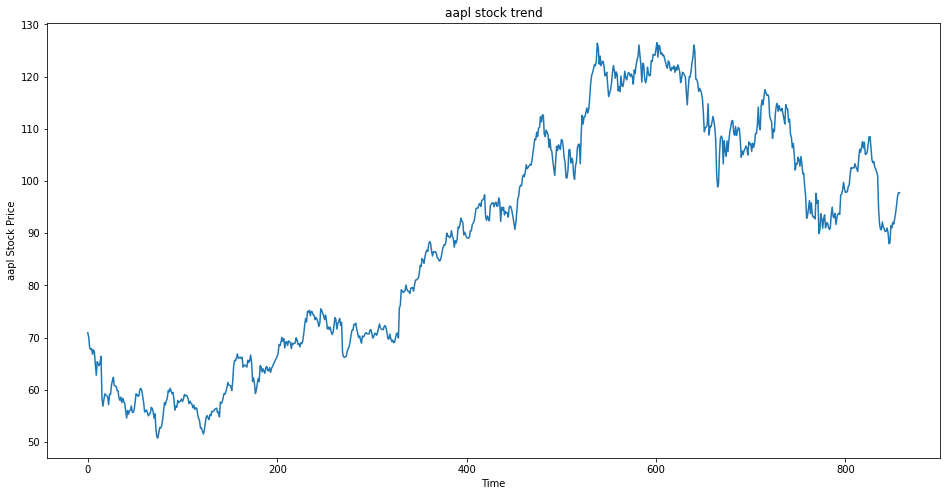

In [36]:
plt.figure(figsize=(16, 8))
plt.plot(training_data_pre_normalized)

plt.title('{} stock trend'.format(stock))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock))



In [37]:
# Create Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [38]:
model = Sequential()
# First layer need to take in specified #features
model.add(LSTM(50, return_sequences=True, input_shape=(3,1))) #Change here if need edit timestep due to lack of data
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_4 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [40]:
# Training the data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 7s 147ms/step - loss: 0.2580 - val_loss: 0.2837
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 0.1211 - val_loss: 0.0241
Epoch 3/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0468 - val_loss: 0.0030
Epoch 4/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0291 - val_loss: 0.0134
Epoch 5/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0162 - val_loss: 0.0012
Epoch 6/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 7/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 8/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 9/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 10/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.003

In [41]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [42]:
# Transforming back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [43]:
print(test_predict)
print(y_test_pre_normalized)

[[ 97.36329 ]
 [ 96.34958 ]
 [ 96.02145 ]
 [ 96.360954]
 [ 96.88262 ]
 [ 97.15202 ]
 [ 97.22386 ]
 [ 97.30992 ]
 [ 96.43828 ]
 [ 95.5557  ]
 [ 95.57463 ]
 [ 95.318634]
 [ 94.95513 ]
 [ 93.65012 ]
 [ 93.7009  ]
 [ 94.12727 ]
 [ 93.85289 ]
 [ 93.35733 ]
 [ 91.540535]
 [ 91.21079 ]
 [ 92.42117 ]
 [ 93.23331 ]
 [ 93.94862 ]
 [ 93.93365 ]
 [ 93.594345]
 [ 94.04897 ]
 [ 94.50934 ]
 [ 95.06019 ]
 [ 95.31029 ]
 [ 95.57603 ]
 [ 95.7588  ]
 [ 96.97558 ]
 [ 97.26016 ]
 [ 97.9033  ]
 [ 97.9083  ]
 [ 97.756966]
 [ 97.13034 ]
 [ 96.268486]
 [ 95.807236]
 [ 97.20478 ]
 [101.3275  ]
 [102.280075]
 [102.58009 ]
 [103.36547 ]
 [102.83168 ]
 [103.93741 ]
 [104.8612  ]
 [106.12163 ]
 [106.724976]
 [106.761024]
 [106.26979 ]
 [106.40751 ]
 [106.91698 ]
 [107.66363 ]
 [107.548   ]
 [107.4309  ]
 [107.360794]
 [107.32014 ]
 [106.82646 ]
 [106.76324 ]
 [106.07872 ]
 [105.60557 ]
 [105.11818 ]
 [104.82882 ]
 [104.40906 ]
 [104.735535]
 [105.39187 ]
 [106.05044 ]
 [105.9762  ]
 [105.38757 ]
 [103.19174 ]
 [102.

In [44]:
# Calculating performance metrics [abso]
import math
from sklearn.metrics import mean_squared_error
MSE_training = mean_squared_error(y_train_pre_normalized, train_predict)
MSE_testing = mean_squared_error(y_test_pre_normalized, test_predict)
RMSE_training = math.sqrt(MSE_training)
RMSE_testing = math.sqrt(MSE_testing)
stats = 'MSE_training = {}, MSE_testing = {}\nRMSE_training = {}, RMSE_testing = {}'.format(MSE_training, MSE_testing, RMSE_training, RMSE_testing)
stats_array = np.array(['MSE_training = {}, MSE_testing = {}'.format(MSE_training, MSE_testing),
                       'RMSE_training = {}, RMSE_testing = {}'.format(RMSE_training, RMSE_testing)])
print(stats)

MSE_training = 1989.4476818705452, MSE_testing = 5.452783352805657
RMSE_training = 44.60322501647774, RMSE_testing = 2.3351195585677527


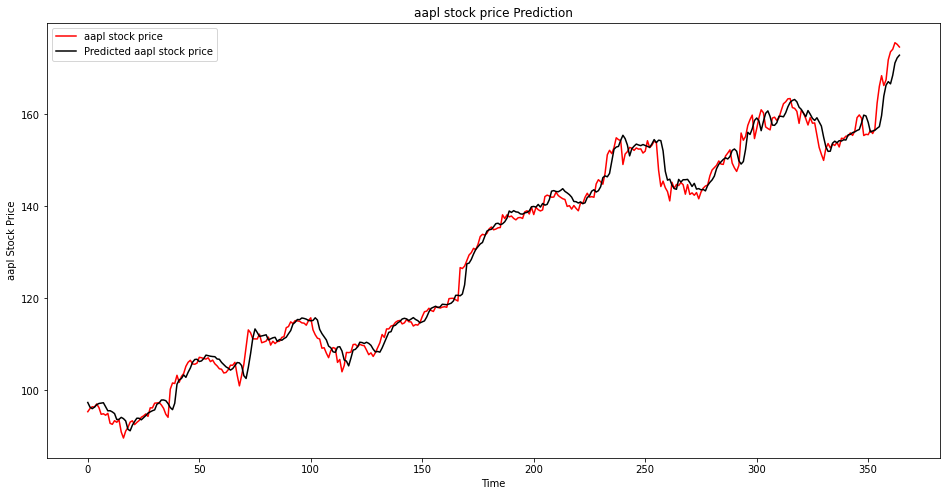

In [45]:
# Plotting the data
plt.figure(figsize=(16, 8))

plt.plot(y_test_pre_normalized, color = 'red', label = '{} stock price'.format(stock))
plt.plot(test_predict, color = 'black', label = 'Predicted {} stock price'.format(stock))
plt.title('{} stock price Prediction'.format(stock))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock))
plt.legend()


In [46]:
# Calculating mean of y